#  Consignes

## Description

Ouvrir le fichier ks-projects-201801.csv, il recense environ 100 000 projets KickStarter. Intégrer les données directement avec L'API Python dans une base de données Mongo. 

Il conviendra de bien spécifier manuellement l'ID du document. Pensez aussi à bien formatter le type des données pour profiter des méthodes implémentées par Mongo. L'ensemble de données n'est pas forcément nécessaire, c'est à vous de créer votre modèle de données.

## Questions

- 1) Récupérer les 5 projets ayant reçu le plus de promesse de dons.
- 2) Compter le nombre de projets ayant atteint leur but.
- 3) Compter le nombre de projets pour chaque catégorie.
- 4) Compter le nombre de projets français ayant été instanciés avant 2016.
- 5) Récupérer les projets américains ayant demandé plus de 200 000 dollars.
- 6) Compter le nombre de projet ayant "Sport" dans leur nom

In [224]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymongo
import datetime

In [157]:
client = pymongo.MongoClient(host=['mongodb://172.18.0.6:27017'])

In [158]:
df_ks = pd.read_csv("./data/ks-projects-201801-sample.csv")
df_ks.head()

/root/.local/share/virtualenvs/code-AFz48Hjb/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6,8,10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real
0,872782264,"Scott Cooper's Solo CD ""A Leg Trick"" (Canceled)",Rock,Music,USD,2011-09-16,2000,2011-08-17 06:31:31,1145,canceled,24,US,1145,1145.000000
1,1326492673,Ohceola jewelry,Fashion,Fashion,USD,2012-08-22,18000,2012-07-23 20:46:48,1851,failed,28,US,1851,1851.000000
2,1688410639,Sluff Off & Harald: Two latest EGGs are Classi...,Tabletop Games,Games,USD,2016-07-19,2000,2016-07-01 21:55:54,7534,successful,254,US,3796,7534.000000
3,156812982,SketchPlanner: Create and Plan- all in one bea...,Art Books,Publishing,USD,2017-09-27,13000,2017-08-28 15:47:02,16298,successful,367,US,2670,16298.000000
4,1835968190,Proven sales with custom motorcycle accessories,Sculpture,Art,CAD,2016-02-24,5000,2016-01-25 17:37:10,1,failed,1,CA,0.708148,0.738225


Ce warning intervient lorsque pandas n'arrive pas à inférer le type de données. Il est sympa il précise les colones 6,8,10,12. 

In [159]:
df_ks.columns[[6,8,10,12]]
print(df_ks.columns)

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real'],
      dtype='object')


## Question 0

### Netoyer les données

In [160]:
df_ks['launched'] = pd.to_datetime(df_ks['launched'], errors='coerce')
df_ks = df_ks.dropna(subset=['launched'])
df_ks.rename(columns={'ID':'project_id'}, inplace=True)
df_ks = df_ks.drop(['main_category','currency','deadline','pledged','backers','usd pledged'],axis=1)

In [161]:
print(df_ks.columns)
df_ks['goal'] = pd.to_numeric(df_ks['goal'])
df_ks['usd_pledged_real'] = pd.to_numeric(df_ks['usd_pledged_real'])

Index(['project_id', 'name', 'category', 'goal', 'launched', 'state',
       'country', 'usd_pledged_real'],
      dtype='object')


In [86]:
from pandas.api.types import is_numeric_dtype
is_numeric_dtype(df_ks['goal'])

True

### Importer les données

In [162]:
projects = df_ks.to_dict(orient='records')
print(projects[0])
type(projects)

{'project_id': 872782264, 'name': 'Scott Cooper\'s Solo CD "A Leg Trick" (Canceled)', 'category': 'Rock', 'goal': 2000.0, 'launched': Timestamp('2011-08-17 06:31:31'), 'state': 'canceled', 'country': 'US', 'usd_pledged_real': 1145.0}


list

In [163]:
db_exercices = client.exercices
collection_kickstarter = db_exercices['kickstarter']

In [164]:
collection_kickstarter.insert_many(projects)

In [165]:
db_exercices.list_collection_names()

['kickstarter']

## Question 1  

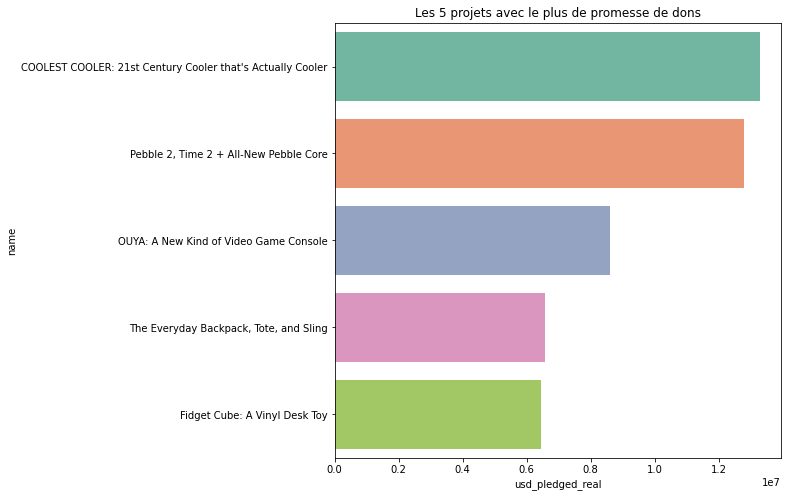

In [243]:
cur = collection_kickstarter.find().sort('usd_pledged_real',-1).limit(5)
result = pd.DataFrame(list(cur))
plt.figure( figsize = (8,8) )
plt.title('Les 5 projets avec le plus de promesse de dons')
sns.barplot(x='usd_pledged_real',y='name',data=result,palette='Set2')
plt.show()

## Question 2

In [240]:
cur = collection_kickstarter.count_documents({'state':'successful'})
failed = collection_kickstarter
print('Nombre de projets ayant atteint leur but:')
print(cur)

Nombre de projets ayant atteint leur but:
53040


## Question 3

In [180]:
category = df_ks.category.value_counts()
index = category.index
for count in range(0,len(index)):
    cur = collection_kickstarter.count_documents({'category':index[count]})
    print(index[count]+':')
    print(cur)

Product Design:
8886
Documentary:
6498
Music:
6229
Tabletop Games:
5581
Shorts:
4857
Video Games:
4799
Food:
4612
Film & Video:
4003
Fiction:
3703
Nonfiction:
3390
Fashion:
3379
Art:
3358
Apparel:
2827
Theater:
2786
Rock:
2707
Technology:
2690
Children's Books:
2686
Apps:
2535
Publishing:
2332
Webseries:
2316
Photography:
2239
Indie Rock:
2192
Narrative Film:
2099
Web:
2017
Comics:
1931
Crafts:
1834
Country & Folk:
1790
Design:
1641
Hip-Hop:
1555
Hardware:
1431
Games:
1331
Pop:
1302
Painting:
1288
Illustration:
1263
Public Art:
1248
Gadgets:
1210
Accessories:
1204
Software:
1194
Mixed Media:
1118
Restaurants:
1089
Art Books:
1065
Classical Music:
1064
Comic Books:
1032
Animation:
1017
Drinks:
995
Playing Cards:
963
Comedy:
923
Dance:
901
Drama:
871
Electronic Music:
858
Performance Art:
855
World Music:
850
Graphic Design:
765
Sculpture:
737
Jazz:
733
Graphic Novels:
702
Small Batch:
701
Food Trucks:
687
Journalism:
672
Mobile Games:
650
Photobooks:
608
Plays:
539
Poetry:
532
Horror:
5

## Question 4 ##

In [214]:
search = datetime.datetime(2016,1,1)
cur = collection_kickstarter.count_documents({'$and':[{'country':'FR'},{'launched':{'$lt':search}}]})
print(cur)

330


## Question 5

In [183]:
cur = collection_kickstarter.find({'$and':[{'country':'US'},{'goal':{'$gte':200000}}]})

for project in cur:
    print(project['name'])

Far from Par is a movie about a man and a talking golf ball.
A CALL TO ADVENTURE
Storybricks, the storytelling online RPG
Shine On New World
Nightclub
Nastaran (Wild Rose)
Hubo - Extension Box for iPhone
Baja ATV Park (Suspended)
Chihuly Installation for Orlando (Pulse Nightclub)
Kurt Vonnegut: Unstuck in Time
The LAKE HOPPER is a VTOL Flying Water Craft Made in America
"Hill" (11 For 11) (From the writer of Rudy & Hoosiers)
Saints of The Classroom
Hemingwrite - A Distraction Free Digital Typewriter
Breakfast 24/7
FJE REVOLT
Austin City Limits 40 Year History Documentary Film
Ozark Mountain Ranch
STEM Lesson Plan - BotBrainï¿½ Educational Products
Guitar Godz VR: A 3D Rock Music Game
The world's first crowd funded millionaire documentary
Creating an online game, "Perdition Online".
The Adventures of Billy Buskirk
MY TINSEL TOWN (Canceled)
Moonlight 5 star (Canceled)
TOMB Adventure 2
The EIFLE S Smart-Mirror W/Front-Facing Camera! (Canceled)
The Brick Cafe
Dangerous Seas: A Beautiful Un

PetWashSPA: The first home SPA system for your pets.
imealhost.com
FOCUS ON THE OCEAN
Ground Branch
Leviathans Online: Monsters In The Sky (Canceled)
William Malone's THALLIUM'S BOX
"PG" Reanimated Cartoons Tha Movie
SportsBucketList.net
Bridging the Minooka area to "Back in the Day"
DMG Recording Studio
ProTap: Draft Beer, Wine, and Cold Beverage Dispenser
The Bobcat Exterior Rodent Bait Station
Edesia: Fresh, homemade and delicious Italian food!
Your Way Game Board
Endorsit: Reviewed by You... Endorsed by the Community
Bobby Rush: Live at the Great Wall of China
A Gangster Movie called,  GET LOUIE
Stark Drive Electric Bike
Atheism is Winning! (Canceled)
Metroryde technology for riders and independent operators
GRANNY, The Movie (starring Jamie Kennedy) (Canceled)
Wining and Dining on the Yacht
Saving Trayvon
Trendy - Style Simplified
The Citizen Body Camera with Tamper-proof Online Backup
The Good Guys (Blood over Everything)
BAD PLANET
Winthrop and Chester (Canceled)
BodyCopter
XCen

## Question 6 

In [184]:
cur = collection_kickstarter.count_documents({'name':{'$regex':'.*sport.*'}})
print(cur)

171
